# Local version for Prediction Test

이 노트북은 텐서플로우를 이용한 얼굴 인식 모델을 개발하기 위해서 로컬 개발환경에서 모델을 개발하고 테스트하기 위한 노트북이다.
그래서, 학습용 파일들은 로컬 디렉토리에 있는 것을 사용하게 된다. 

## Define graph and restore session

In [1]:
import tensorflow as tf
import numpy as np
import re
from datetime import datetime

flags = tf.app.flags
FLAGS = flags.FLAGS
FLAGS.image_size = 96
FLAGS.image_color = 3
FLAGS.maxpool_filter_size = 2
FLAGS.num_classes=5
FLAGS.batch_size=100
FLAGS.learning_rate = 0.0001
FLAGS.log_dir='/Users/terrycho/'

def get_input_queue(csv_file_name,num_epochs = None):
    train_images = []
    train_labels = []
    for line in open(csv_file_name,'r'):
        cols = re.split(',|\n',line)
        train_images.append(cols[0])
        # 3rd column is label and needs to be converted to int type
        train_labels.append(int(cols[2]) )
                            
    input_queue = tf.train.slice_input_producer([train_images,train_labels],
                                               num_epochs = num_epochs,shuffle = True)
    
    return input_queue

def read_data(input_queue):
    image_file = input_queue[0]
    label = input_queue[1]
    
    image =  tf.image.decode_jpeg(tf.read_file(image_file),channels=FLAGS.image_color)
    
    return image,label,image_file

def read_data_batch(csv_file_name,batch_size=FLAGS.batch_size):
    input_queue = get_input_queue(csv_file_name)
    image,label,file_name= read_data(input_queue)
    image = tf.reshape(image,[FLAGS.image_size,FLAGS.image_size,FLAGS.image_color])
    
    # random image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image,max_delta=0.5)
    image = tf.image.random_contrast(image,lower=0.2,upper=2.0)
    image = tf.image.random_hue(image,max_delta=0.08)
    image = tf.image.random_saturation(image,lower=0.2,upper=2.0)
    
    batch_image,batch_label,batch_file = tf.train.batch([image,label,file_name],batch_size=batch_size)
    #,enqueue_many=True)
    batch_file = tf.reshape(batch_file,[batch_size,1])

    batch_label_on_hot=tf.one_hot(tf.to_int64(batch_label),
        FLAGS.num_classes, on_value=1.0, off_value=0.0)
    return batch_image,batch_label_on_hot,batch_file

# convolutional network layer 1
def conv1(input_data):
    # layer 1 (convolutional layer)
    FLAGS.conv1_filter_size = 3
    FLAGS.conv1_layer_size = 16
    FLAGS.stride1 = 1
    
    with tf.name_scope('conv_1'):
        W_conv1 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv1_filter_size,FLAGS.conv1_filter_size,FLAGS.image_color,FLAGS.conv1_layer_size],
                                              stddev=0.1))
        b1 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv1_layer_size],stddev=0.1))
        h_conv1 = tf.nn.conv2d(input_data,W_conv1,strides=[1,1,1,1],padding='SAME')
        h_conv1_relu = tf.nn.relu(tf.add(h_conv1,b1))
        h_conv1_maxpool = tf.nn.max_pool(h_conv1_relu
                                        ,ksize=[1,2,2,1]
                                        ,strides=[1,2,2,1],padding='SAME')
        
        
    return h_conv1_maxpool

# convolutional network layer 2
def conv2(input_data):
    FLAGS.conv2_filter_size = 3
    FLAGS.conv2_layer_size = 32
    FLAGS.stride2 = 1
    
    with tf.name_scope('conv_2'):
        W_conv2 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv2_filter_size,FLAGS.conv2_filter_size,FLAGS.conv1_layer_size,FLAGS.conv2_layer_size],
                                              stddev=0.1))
        b2 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv2_layer_size],stddev=0.1))
        h_conv2 = tf.nn.conv2d(input_data,W_conv2,strides=[1,1,1,1],padding='SAME')
        h_conv2_relu = tf.nn.relu(tf.add(h_conv2,b2))
        h_conv2_maxpool = tf.nn.max_pool(h_conv2_relu
                                        ,ksize=[1,2,2,1]
                                        ,strides=[1,2,2,1],padding='SAME')
        
        
    return h_conv2_maxpool

# convolutional network layer 3
def conv3(input_data):
    FLAGS.conv3_filter_size = 3
    FLAGS.conv3_layer_size = 64
    FLAGS.stride3 = 1
    
    print ('## FLAGS.stride1 ',FLAGS.stride1)
    with tf.name_scope('conv_3'):
        W_conv3 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv3_filter_size,FLAGS.conv3_filter_size,FLAGS.conv2_layer_size,FLAGS.conv3_layer_size],
                                              stddev=0.1))
        b3 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv3_layer_size],stddev=0.1))
        h_conv3 = tf.nn.conv2d(input_data,W_conv3,strides=[1,1,1,1],padding='SAME')
        h_conv3_relu = tf.nn.relu(tf.add(h_conv3,b3))
        h_conv3_maxpool = tf.nn.max_pool(h_conv3_relu
                                        ,ksize=[1,2,2,1]
                                        ,strides=[1,2,2,1],padding='SAME')
        
        
    return h_conv3_maxpool

# convolutional network layer 3
def conv4(input_data):
    FLAGS.conv4_filter_size = 5
    FLAGS.conv4_layer_size = 128
    FLAGS.stride4 = 1
    
    with tf.name_scope('conv_4'):
        W_conv4 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv4_filter_size,FLAGS.conv4_filter_size,FLAGS.conv3_layer_size,FLAGS.conv4_layer_size],
                                              stddev=0.1))
        b4 = tf.Variable(tf.truncated_normal(
                        [FLAGS.conv4_layer_size],stddev=0.1))
        h_conv4 = tf.nn.conv2d(input_data,W_conv4,strides=[1,1,1,1],padding='SAME')
        h_conv4_relu = tf.nn.relu(tf.add(h_conv4,b4))
        h_conv4_maxpool = tf.nn.max_pool(h_conv4_relu
                                        ,ksize=[1,2,2,1]
                                        ,strides=[1,2,2,1],padding='SAME')
        
        
    return h_conv4_maxpool

# fully connected layer 1
def fc1(input_data):
    input_layer_size = 6*6*FLAGS.conv4_layer_size
    FLAGS.fc1_layer_size = 512
    
    with tf.name_scope('fc_1'):
        # 앞에서 입력받은 다차원 텐서를 fcc에 넣기 위해서 1차원으로 피는 작업
        input_data_reshape = tf.reshape(input_data, [-1, input_layer_size])
        W_fc1 = tf.Variable(tf.truncated_normal([input_layer_size,FLAGS.fc1_layer_size],stddev=0.1))
        b_fc1 = tf.Variable(tf.truncated_normal(
                        [FLAGS.fc1_layer_size],stddev=0.1))
        h_fc1 = tf.add(tf.matmul(input_data_reshape,W_fc1) , b_fc1) # h_fc1 = input_data*W_fc1 + b_fc1
        h_fc1_relu = tf.nn.relu(h_fc1)
    
    return h_fc1_relu
    
# fully connected layer 2
def fc2(input_data):
    FLAGS.fc2_layer_size = 256
    
    with tf.name_scope('fc_2'):
        W_fc2 = tf.Variable(tf.truncated_normal([FLAGS.fc1_layer_size,FLAGS.fc2_layer_size],stddev=0.1))
        b_fc2 = tf.Variable(tf.truncated_normal(
                        [FLAGS.fc2_layer_size],stddev=0.1))
        h_fc2 = tf.add(tf.matmul(input_data,W_fc2) , b_fc2) # h_fc1 = input_data*W_fc1 + b_fc1
        h_fc2_relu = tf.nn.relu(h_fc2)
    
    return h_fc2_relu

# final layer
def final_out(input_data):

    with tf.name_scope('final_out'):
        W_fo = tf.Variable(tf.truncated_normal([FLAGS.fc2_layer_size,FLAGS.num_classes],stddev=0.1))
        b_fo = tf.Variable(tf.truncated_normal(
                        [FLAGS.num_classes],stddev=0.1))
        h_fo = tf.add(tf.matmul(input_data,W_fo) , b_fo) # h_fc1 = input_data*W_fc1 + b_fc1
        
    # 최종 레이어에 softmax 함수는 적용하지 않았다. 
        
    return h_fo

# build cnn_graph
def build_model(images,keep_prob):
    # define CNN network graph
    # output shape will be (*,48,48,16)
    r_cnn1 = conv1(images) # convolutional layer 1
    print ("shape after cnn1 ",r_cnn1.get_shape())
    
    # output shape will be (*,24,24,32)
    r_cnn2 = conv2(r_cnn1) # convolutional layer 2
    print ("shape after cnn2 :",r_cnn2.get_shape() )
    
    # output shape will be (*,12,12,64)
    r_cnn3 = conv3(r_cnn2) # convolutional layer 3
    print ("shape after cnn3 :",r_cnn3.get_shape() )

    # output shape will be (*,6,6,128)
    r_cnn4 = conv4(r_cnn3) # convolutional layer 4
    print ("shape after cnn4 :",r_cnn4.get_shape() )
    
    # fully connected layer 1
    r_fc1 = fc1(r_cnn4)
    print ("shape after fc1 :",r_fc1.get_shape() )

    # fully connected layer2
    r_fc2 = fc2(r_fc1)
    print ("shape after fc2 :",r_fc2.get_shape() )
    
    ## drop out
    # 참고 http://stackoverflow.com/questions/34597316/why-input-is-scaled-in-tf-nn-dropout-in-tensorflow
    # 트레이닝시에는 keep_prob < 1.0 , Test 시에는 1.0으로 한다. 
    r_dropout = tf.nn.dropout(r_fc2,keep_prob)
    print ("shape after dropout :",r_dropout.get_shape() ) 
    
    # final layer
    r_out = final_out(r_dropout)
    print ("shape after final layer :",r_out.get_shape() )


    return r_out 


# build graph
images = tf.placeholder(tf.float32,[None,FLAGS.image_size,FLAGS.image_size,FLAGS.image_color])
keep_prob = tf.placeholder(tf.float32) # dropout ratio

prediction = tf.nn.softmax(build_model(images,keep_prob))
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, 'face_recog')
    

('shape after cnn1 ', TensorShape([Dimension(None), Dimension(48), Dimension(48), Dimension(16)]))
('shape after cnn2 :', TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(32)]))
('## FLAGS.stride1 ', 1)
('shape after cnn3 :', TensorShape([Dimension(None), Dimension(12), Dimension(12), Dimension(64)]))
('shape after cnn4 :', TensorShape([Dimension(None), Dimension(6), Dimension(6), Dimension(128)]))
('shape after fc1 :', TensorShape([Dimension(None), Dimension(512)]))
('shape after fc2 :', TensorShape([Dimension(None), Dimension(256)]))
('shape after dropout :', TensorShape([Dimension(None), Dimension(256)]))
('shape after final layer :', TensorShape([Dimension(None), Dimension(5)]))
INFO:tensorflow:Restoring parameters from face_recog


## Read image file 


In [19]:
imagefile = 'sulhyun2.jpg'

In [20]:
!ls -al $imagefile

-rw-r--r--  1 terrycho  google  19219 Jun 13 23:20 sulhyun2.jpg


## Crop image with vision API

[INFO] processing sulhyun2.jpg
number of faces  1
Original image


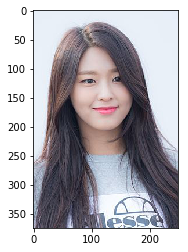

Detect face boundary box 


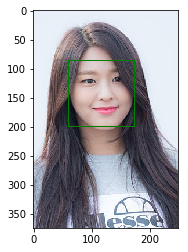

Cropped image


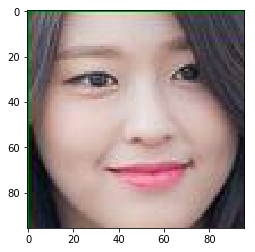

Jessica Alba 0.000000
Angelina Jolie 0.000000
Nicole Kidman 0.000000
Sulhyun 1.000000
Victoria Beckam 0.000000


In [22]:
import google.auth
import io
import os
from oauth2client.client import GoogleCredentials
from google.cloud import vision
from PIL import Image
from PIL import ImageDraw

FLAGS.image_size = 96

# set service account file into OS environment value
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/terrycho/keys/terrycho-ml.json"

visionClient = vision.Client()
print ('[INFO] processing %s'%(imagefile))

#detect face
image = visionClient.image(filename=imagefile)
faces = image.detect_faces()
face = faces[0]

print 'number of faces ',len(faces)

#get face location in the photo 
left = face.fd_bounds.vertices[0].x_coordinate
top = face.fd_bounds.vertices[0].y_coordinate
right = face.fd_bounds.vertices[2].x_coordinate
bottom = face.fd_bounds.vertices[2].y_coordinate
rect = [left,top,right,bottom]

fd = io.open(imagefile,'rb')
image = Image.open(fd)

import matplotlib.pyplot as plt
# display original image
print "Original image"
plt.imshow(image)
plt.show()


# draw green box for face in the original image
print "Detect face boundary box "
draw = ImageDraw.Draw(image)
draw.rectangle(rect,fill=None,outline="green")

plt.imshow(image)
plt.show()

crop = image.crop(rect)
im = crop.resize((FLAGS.image_size,FLAGS.image_size),Image.ANTIALIAS)
plt.show()
im.save('cropped'+imagefile)

print "Cropped image"
tfimage = tf.image.decode_jpeg(tf.read_file('cropped'+imagefile),channels=3)
tfimage_value = tfimage.eval()
tfimages = []
tfimages.append(tfimage_value)
plt.imshow(tfimage_value)
plt.show()
fd.close()
          
p_val = sess.run(prediction,feed_dict={images:tfimages,keep_prob:1.0})
name_labels = ['Jessica Alba','Angelina Jolie','Nicole Kidman','Sulhyun','Victoria Beckam']
i = 0
for p in p_val[0]:
    print('%s %f'% (name_labels[i],float(p)) )
    i = i + 1

In [ ]:
!ls *.jpg


vision api usage : reference https://googlecloudplatform.github.io/google-cloud-python/latest/vision-usage.html
    